In [1]:
import json
from pathlib import Path

import pandas as pd


def _parse_data(file_path: str | Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    cocktail_df = pd.read_json(Path(file_path).resolve())

    with open(Path(file_path).resolve()) as file:
        data = json.load(file)

    ingredients_df = pd.json_normalize(data, 'ingredients')

    return cocktail_df, ingredients_df

In [2]:
dataset_path = Path.cwd().parent / "data" / "cocktail_dataset.json"
cocktail_df, ingredients_df = _parse_data(dataset_path)

In [3]:
cocktail_df.head(5)

,id,name,category,glass,tags,instructions,imageUrl,alcoholic,createdAt,updatedAt,ingredients
0,11000,Mojito,Cocktail,Highball glass,"[IBA, ContemporaryClassic, Alcoholic, USA, Asi...",Muddle mint leaves with sugar and lime juice. ...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:17.000+00:00,2024-08-18T19:06:16.000+00:00,"[{'id': 170, 'name': 'Soda water', 'descriptio..."
1,11001,Old Fashioned,Cocktail,Old-fashioned glass,"[IBA, Classic, Alcoholic, Expensive, Savory]",Place sugar cube in old fashioned glass and sa...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 513, 'name': 'Water', 'description': '..."
2,11002,Long Island Tea,Ordinary Drink,Highball glass,"[Strong, Asia, StrongFlavor, Brunch, Vegetaria...",Combine all ingredients (except cola) and pour...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 305, 'name': 'Light Rum', 'description..."
3,11003,Negroni,Ordinary Drink,Old-fashioned glass,"[IBA, Classic]","Stir into glass over ice, garnish and serve.",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 482, 'name': 'Sweet Vermouth', 'descri..."
4,11004,Whiskey Sour,Ordinary Drink,Old-fashioned glass,"[IBA, Classic, Alcoholic, ContemporaryClassic]","Shake with ice. Strain into chilled glass, gar...",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:59.000+00:00,2024-08-18T19:06:18.000+00:00,"[{'id': 409, 'name': 'Powdered Sugar', 'descri..."


In [ ]:
def extract_ingredient_features(row):
    ingredients = row.get('ingredients', [])
    total_ingredients = len(ingredients)
    alcoholic_ingredients = sum(
        1 for ing in ingredients
        if ing.get('alcohol', 0) == 1
    )
    non_alcoholic_ingredients = total_ingredients - alcoholic_ingredients
    return pd.Series({
        'total_ingredients': total_ingredients,
        'alcoholic_ingredients': alcoholic_ingredients,
        'non_alcoholic_ingredients': non_alcoholic_ingredients
    })

In [5]:
cocktail_df = pd.concat([
    cocktail_df,
    cocktail_df.apply(extract_ingredient_features, axis=1)
], axis=1)
cocktail_df = cocktail_df.drop(columns=["id", "createdAt", "updatedAt", "imageUrl", "tags", "instructions", "category", "alcoholic", "ingredients"])
cocktail_df.head(5)

,name,glass,total_ingredients,alcoholic_ingredients,non_alcoholic_ingredients
0,Mojito,Highball glass,5,2,3
1,Old Fashioned,Old-fashioned glass,4,1,3
2,Long Island Tea,Highball glass,6,4,2
3,Negroni,Old-fashioned glass,3,3,0
4,Whiskey Sour,Old-fashioned glass,4,1,3


In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = cocktail_df[["glass", "total_ingredients", "alcoholic_ingredients", "non_alcoholic_ingredients"]]

label_encoders = {}
le = LabelEncoder()
X["glass"] = le.fit_transform(X["glass"])
label_encoders["glass"] = le

# Selecting numerical columns
numerical_cols = ["glass", "total_ingredients", "alcoholic_ingredients", "non_alcoholic_ingredients"]

# Standardizing numerical columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

/tmp/ipykernel_270800/2803890532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["glass"] = le.fit_transform(X["glass"])
/tmp/ipykernel_270800/2803890532.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [7]:
X.head(5)

,glass,total_ingredients,alcoholic_ingredients,non_alcoholic_ingredients
0,0.452492,0.819279,0.202196,0.621811
1,0.867793,0.029470,-1.152515,0.621811
2,0.452492,1.609087,2.911617,-0.078379
3,0.867793,-0.760338,1.556906,-1.478760
4,0.867793,0.029470,-1.152515,0.621811


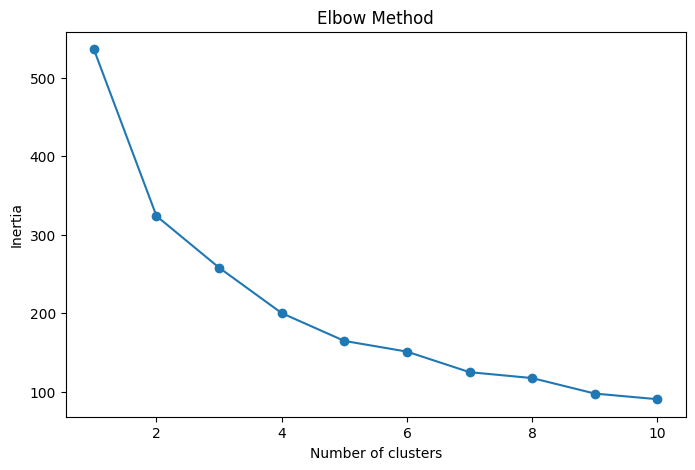

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

cocktail_df['cluster'] = kmeans.labels_

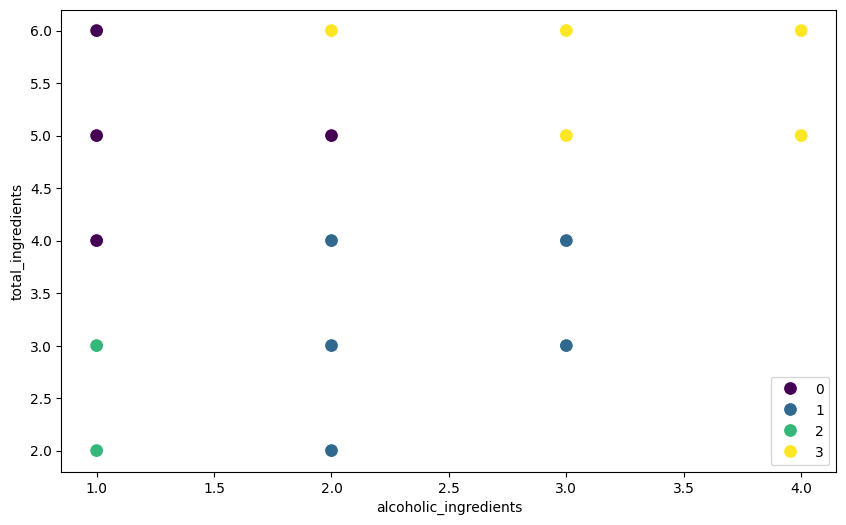

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=cocktail_df['alcoholic_ingredients'], y=cocktail_df['total_ingredients'], hue=cocktail_df['cluster'], palette='viridis', s=100)
plt.title('')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)


def evaluate_clustering(model, data):
    inertia = model.inertia_
    silhouette_avg = silhouette_score(data, model.labels_)
    calinski_score = calinski_harabasz_score(data, model.labels_)
    davies_bouldin = davies_bouldin_score(data, model.labels_)

    print(f"Inertia (SSE): {inertia:.2f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_score:.2f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")

evaluate_clustering(kmeans, X)

Inertia (SSE): 200.21
Silhouette Score: 0.3475
Calinski-Harabasz Score: 72.68
Davies-Bouldin Score: 1.0783
